In [8]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import numpy as np
from scipy.ndimage import zoom
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import requests

plt.rcParams['figure.figsize'] = (10., 6.)

In [9]:
response = requests.get('https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt')
stopwords = response.text.split('\n')
stopwords.append("'s")
stopwords.append('_')

In [5]:
id2word = Dictionary.load('full_corpus_dictionary')

In [6]:
lda = LdaModel.load('full_corpus_lda')

In [7]:
token_window = 100

In [12]:
def get_topics(entities_path, tokens_path, character_of_interest):
    entities_df = pd.read_csv(entities_path)
    tokens_df = pd.read_csv(tokens_path, delimiter='\t')

    mentions_df = entities_df[entities_df.character_name == character_of_interest]

    mention_documents = []
    for _, row in mentions_df.iterrows():
        mention_tokens = []
        for _, token_row in tokens_df[max(row.start_token - token_window, 0):min(row.end_token + token_window, len(tokens_df) - 1)].iterrows():
            if token_row.POS_tag != 'PUNCT' and token_row.lemma.lower().strip() not in stopwords and not all(char.isdigit() for char in token_row.lemma.strip()):
                mention_tokens.append(token_row.lemma)
        mention_documents.append(mention_tokens)
        
    mention_corpus = [id2word.doc2bow(text) for text in mention_documents]

    topics_overtime = [list() for _ in range(100)]
    for mention in mention_corpus:
        topics = {id_: score for id_, score in lda[mention][0]}
        for i in range(100):
            topics_overtime[i].append(topics.get(i, 0))

    N = 1000
    rolling_averages = {}
    for topic_idx, scores in enumerate(topics_overtime):
        rolling_average = pd.Series(scores).rolling(window=N).mean().iloc[N-1:].values
        rolling_averages[topic_idx] = rolling_average

    return rolling_averages

In [23]:
dorian_gray_rolling_averages = get_topics(
    '../data/DorianGray/processed_characters.csv',
    '../data/DorianGray/character-tagging/DorianGray.tokens',
    'Mr. Dorian Gray'
)

pride_and_prejudice_rolling_averages = get_topics(
    '../data/PrideAndPredjudice/processed_characters.csv',
    '../data/PrideAndPredjudice/character-tagging/PrideAndPredjudice.tokens',
    'the eldest Miss Bennet'
)

silas_marner_rolling_averages = get_topics(
    '../data/SilasMarner/processed_characters.csv',
    '../data/SilasMarner/character-tagging/SilasMarner.tokens',
    'father Silas , who had taken her golden curls for his lost guineas brought back to him'
)

christmas_carol_rolling_averages = get_topics(
    '../data/ChristmasCarol/processed_characters.csv',
    '../data/ChristmasCarol/character-tagging/ChristmasCarol.tokens',
    'Mr. Ebenezer Scrooge'
)

In [68]:
dg_top_topics = sorted(dorian_gray_rolling_averages, key=lambda x: sum(dorian_gray_rolling_averages[x]), reverse=True)#[:15]
pp_top_topics = sorted(pride_and_prejudice_rolling_averages, key=lambda x: sum(pride_and_prejudice_rolling_averages[x]), reverse=True)[:15]
cc_top_topics = sorted(silas_marner_rolling_averages, key=lambda x: sum(silas_marner_rolling_averages[x]), reverse=True)[:15]
sm_top_topics = sorted(christmas_carol_rolling_averages, key=lambda x: sum(christmas_carol_rolling_averages[x]), reverse=True)[:15]

top_topics = set(dg_top_topics + pp_top_topics + cc_top_topics + sm_top_topics)
len(top_topics)

100

In [69]:
max_length = max(
    len(dorian_gray_rolling_averages[0]),
    len(pride_and_prejudice_rolling_averages[0]),
    len(silas_marner_rolling_averages[0]),
    len(christmas_carol_rolling_averages[0]),
)
max_length

3259

In [70]:
dorian_gray_filtered_rolling_averages = {key: val for key, val in dorian_gray_rolling_averages.items() if key in top_topics}
pride_and_prejudice_filtered_rolling_averages = {key: val for key, val in pride_and_prejudice_rolling_averages.items() if key in top_topics}
silas_marner_filtered_rolling_averages = {key: val for key, val in silas_marner_rolling_averages.items() if key in top_topics}
christmas_carol_filtered_rolling_averages = {key: val for key, val in christmas_carol_rolling_averages.items() if key in top_topics}

In [71]:
def build_feature_vector(topic_averages, max_length):
    topic_matrix = []
    for topic_vector in topic_averages.values():
        zoom_rate = max_length / len(topic_vector)
        zoomed = zoom(topic_vector, zoom_rate)
        topic_matrix.append(zoomed)

    return np.array(topic_matrix).flatten()

dg_vector = build_feature_vector(dorian_gray_filtered_rolling_averages, min_length)
pp_vector = build_feature_vector(pride_and_prejudice_filtered_rolling_averages, min_length)
cc_vector = build_feature_vector(christmas_carol_filtered_rolling_averages, min_length)
sm_vector = build_feature_vector(silas_marner_filtered_rolling_averages, min_length)

In [72]:
all_aligned = np.array([dg_vector, sm_vector, cc_vector, pp_vector])

pairwise_cosine_similarity = cosine_similarity(all_aligned, all_aligned)

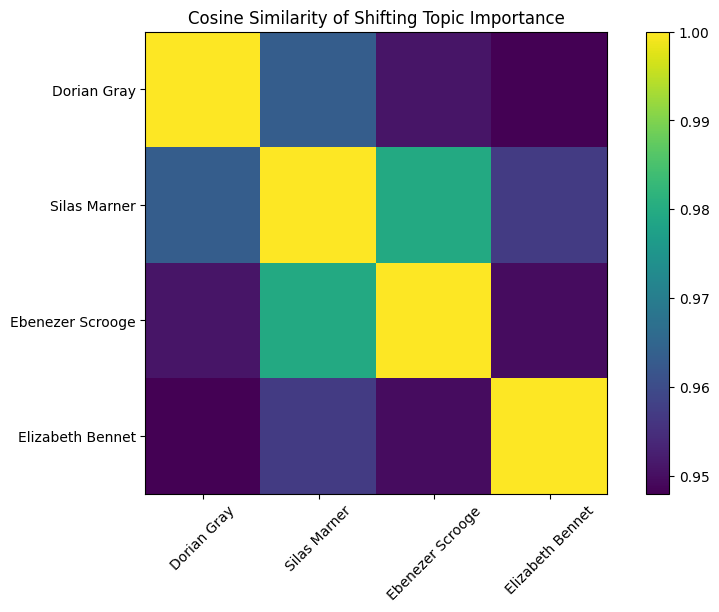

In [86]:
fig, ax = plt.subplots()
pos = ax.imshow(pairwise_cosine_similarity)
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(['Dorian Gray', 'Silas Marner', 'Ebenezer Scrooge', 'Elizabeth Bennet'], rotation=45)
ax.set_yticklabels(['Dorian Gray', 'Silas Marner', 'Ebenezer Scrooge', 'Elizabeth Bennet'])
ax.set_title('Cosine Similarity of Shifting Topic Importance')
fig.colorbar(pos, ax=ax)
plt.savefig('cosine_sim_topics.png')
plt.show()

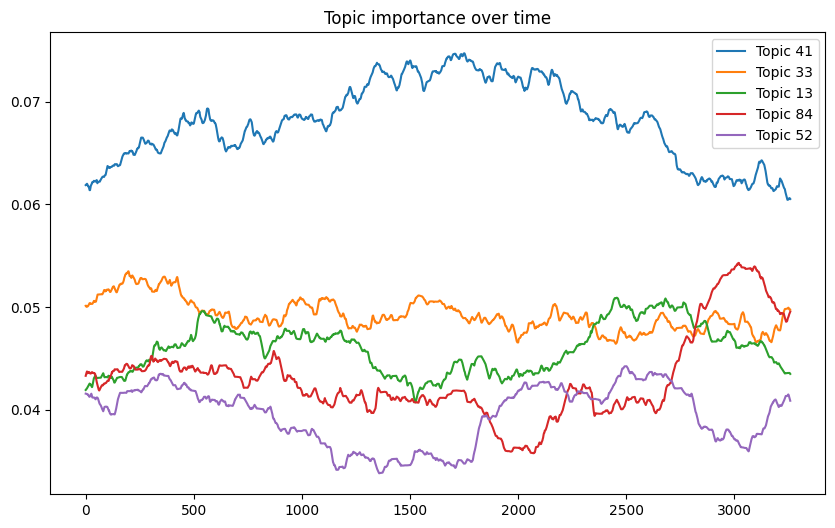

In [84]:
x = np.arange(len(pride_and_prejudice_rolling_averages[1]))

for topic_id in sorted(pride_and_prejudice_rolling_averages, key=lambda x: sum(pride_and_prejudice_rolling_averages[x]), reverse=True)[:5]:
    rolling_average = pride_and_prejudice_rolling_averages[topic_id]
    plt.plot(x, rolling_average, label=f'Topic {topic_id}')

plt.legend()
plt.title('Topic importance over time')
plt.savefig('pp_topics')
plt.show()

In [85]:
for key in sorted(pride_and_prejudice_rolling_averages, key=lambda x: sum(pride_and_prejudice_rolling_averages[x]), reverse=True)[:5]:
    print(f'Topic {key}: {[word for word, score in lda.show_topic(key, topn=15)]}')

Topic 41: ['time', 'feeling', 'evening', 'sort', 'minute', 'master', 'month', 'story', 'society', 'mere', 'gain', 'conscious', 'sorrow', 'terror', 'escape']
Topic 33: ['mind', 'hope', 'tone', 'doubt', 'cold', 'account', 'pity', 'drawing', 'sad', 'alter', 'treat', 'reproach', 'proper', 'shop', 'inform']
Topic 13: ['hear', 'moment', 'truth', 'glance', 'ready', 'ease', 'remark', 'spare', 'indifferent', 'finish', 'brush', 'hesitate', 'mix', '18th', '15th']
Topic 84: ['marry', 'wife', 'meet', 'marriage', 'laugh', 'party', 'forget', 'charm', 'dine', 'absurd', 'hospitality', 'scruple', 'honoured', '15th', 'heal']
Topic 52: ['speak', 'eye', 'care', 'heart', 'intend', 'guess', 'curious', 'heal', 'concerned', 'demean', 'disagreement', 'disrespectful', 'bounty', 'ladyship', 'occasional']
